### Trying to cluster

In [1]:
import functions
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [4]:
# Folder containing the data
folder_path = "FC_matrices_times_wp11/"

# keep only ROIS
rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 10, 11, 12, 54, 56, 78, 96, 190, 191, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]

t1_matrices, rsfMRI_full_info, rsfMRI_info, t1_subjects = functions.load_data_T1_only(folder_path, rois)
matrices, rsfMRI_full_info, rsfMRI_info, subjects = functions.load_data(folder_path, rois)
#matrices = functions.matrices_to_wide_df(matrices)

In [7]:
print("matrices shape: ", np.shape(matrices))
print("t1_matrices shape: ", np.shape(t1_matrices))

matrices shape:  ()
t1_matrices shape:  (22, 37, 37)


In [6]:
print("matrices column names: ", matrices.columns)

AttributeError: 'dict' object has no attribute 'columns'

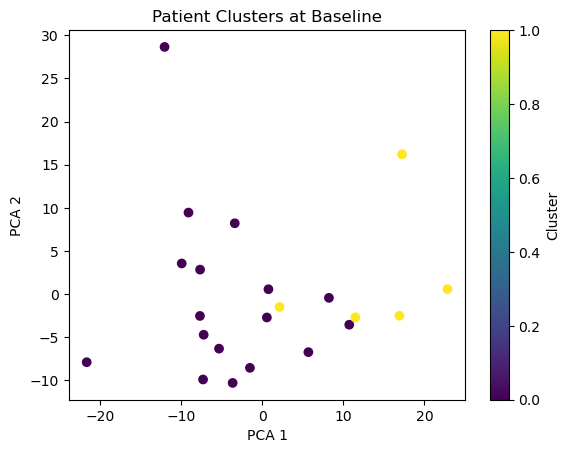

In [11]:
baseline_matrices = matrices['T1_matrix']

def flatten_upper(mat):
    mat = mat.values if isinstance(mat, pd.DataFrame) else mat  # ensure it's an array
    return mat[np.triu_indices_from(mat, k=1)]

X = np.array([flatten_upper(m) for m in baseline_matrices])
subject_ids = matrices.loc[baseline_matrices.index, 'subject_id'].tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42) # 3 clusters seems to work best in plot below, but have to check again with silhouette score
labels = kmeans.fit_predict(X_scaled)  # shape: (22,)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title("Patient Clusters at Baseline")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()


In [12]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_scaled, labels)
print(f"Silhouette score: {score}")


Silhouette score: 0.09456492624101184


In [13]:
# Assuming `baseline_matrices` is a Pandas Series containing your matrices
subject_ids = matrices.loc[baseline_matrices.index, 'subject_id'].tolist()

# Create a DataFrame with subject IDs and their corresponding cluster labels
subject_cluster_df = pd.DataFrame({'subject_id': subject_ids, 'cluster': labels})

# Group subjects by cluster label
grouped_subjects = subject_cluster_df.groupby('cluster')['subject_id'].apply(list).to_dict()

# Print subjects in each cluster
for cluster, subjects in grouped_subjects.items():
    print(f"Cluster {cluster}: {subjects}")

Cluster 0: ['s036', 's008', 's039', 's006', 's001', 's041', 's014', 's013', 's057', 's068', 's067', 's027', 's016', 's011', 's074', 's019', 's075']
Cluster 1: ['s003', 's042', 's017', 's021', 's081']


In [14]:
# Create a DataFrame mapping subject IDs to their cluster labels
subject_cluster_df = pd.DataFrame({'subject_id': subject_ids, 'cluster': labels})

# Merge the cluster DataFrame with the original DataFrame (matrices)
matrices_with_clusters = matrices.merge(subject_cluster_df, on='subject_id', how='left')

# Show the updated DataFrame with the cluster column
print(matrices_with_clusters.head())

  subject_id                                          T1_matrix  \
0       s036            362       363       364       367  3...   
1       s008            362       363       364       367   ...   
2       s039            362       363       364       367   ...   
3       s006            362       363       364       367   ...   
4       s001            362       363       364       367   ...   

                                           T2_matrix  \
0            362       363       364       367   ...   
1            362       363       364       367   ...   
2            362       363       364       367   ...   
3            362       363       364       367   ...   
4            362       363       364       367   ...   

                                           T3_matrix  \
0            362       363       364       367   ...   
1            362       363       364       367   ...   
2            362       363       364       367   ...   
3            362       363       364

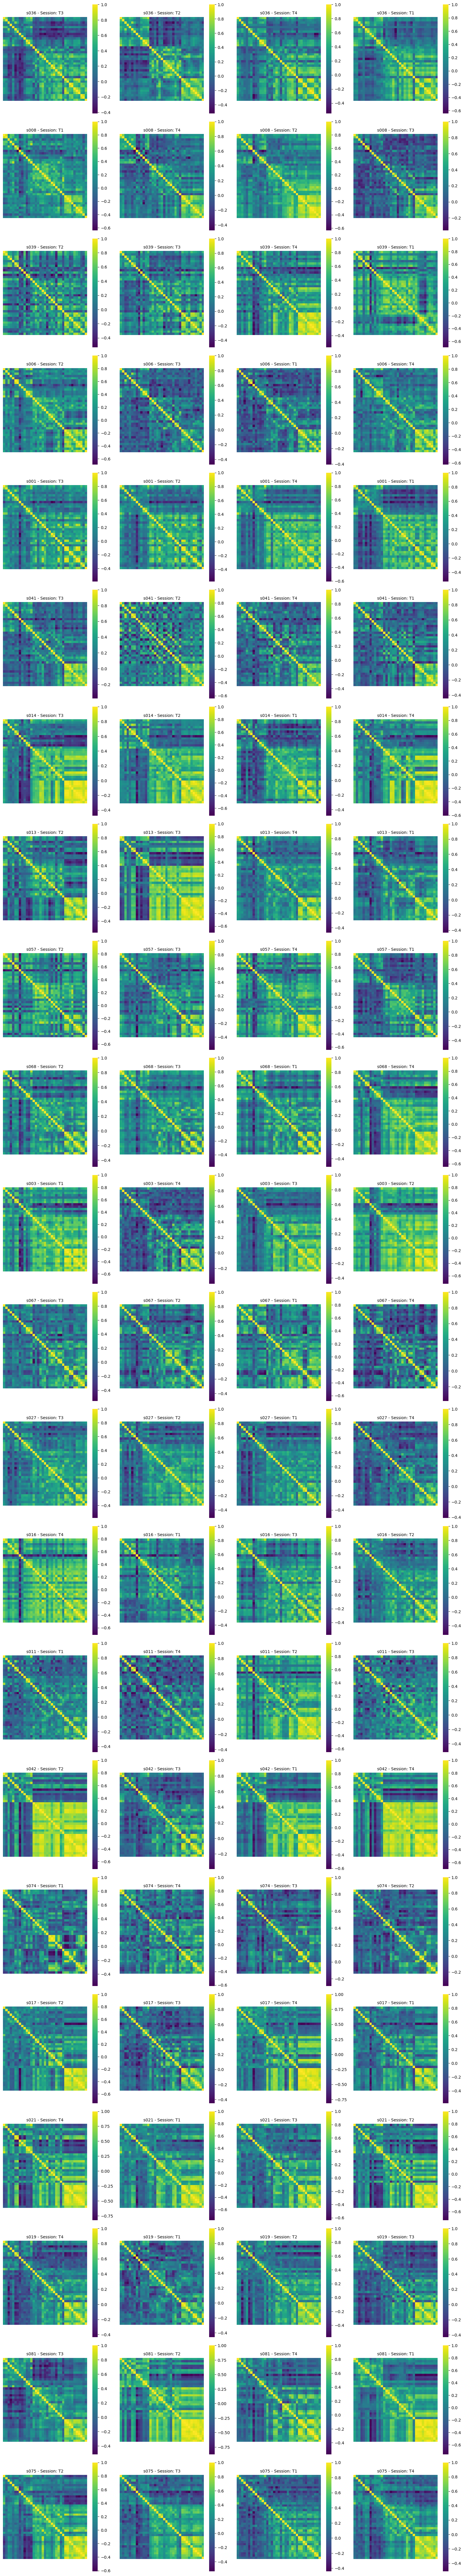

In [15]:
functions.plot_all_subject_matrices(folder_path, rois)

### Adding some data